# Cross-Topic Quotes Generation using Word Embeddings
- Rohak Singhal, Ish Handa 2018/05/28

In [1]:
import re
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Preprocessing

1. Load the Quotes dataset and choose 10 topics to generate new quotes from
2. Clean the dataset - make lowercase, remove punctuations (apart from . and , )
3. Save the cleaned quotes in 10 seperate files and an additional file with quotes from all topics
4. Tokenize words using the file with all cleaned quotes
5. Creating a Word Embedding Matrix for each Tokenized word using GloVe pretained word vectors   

### 1. The Quotes Dataset

Retrieved from [here](https://www.researchgate.net/publication/304742521_CSV_dataset_of_76000_quotes_suitable_for_quotes_recommender_systems_or_other_analysis). This is the first time that this dataset is being used for machine learning, since there are no citations involving it.

In [2]:
data = pd.read_csv('data/quotes_all.csv',delimiter=';')
data.head()

,Quote,Author,Topic
0,Age is an issue of mind over matter. If you do...,Mark Twain,age
1,"Anyone who stops learning is old, whether at t...",Henry Ford,age
2,Wrinkles should merely indicate where smiles h...,Mark Twain,age
3,True terror is to wake up one morning and disc...,Kurt Vonnegut,age
4,A diplomat is a man who always remembers a wom...,Robert Frost,age


Distribution of Quotes over the topics:

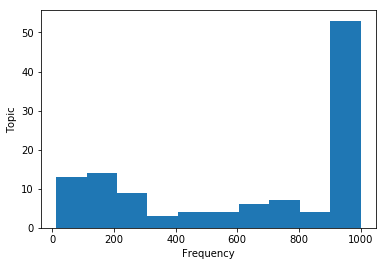

In [3]:
topic_counts = []
for topic in data['Topic'].unique():
    topic_counts.append(sum(data['Topic']==topic))

plt.hist(topic_counts)
plt.xlabel('Frequency')
plt.ylabel('Topic')
plt.show()

Around 50 files contain more than 900 quotes. Now to find out the distribution of words over quotes:

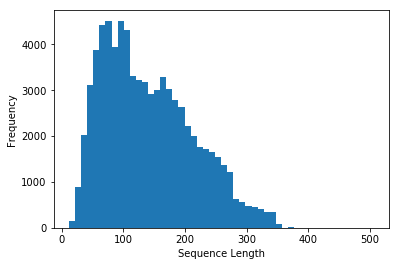

In [4]:
num_words = []
for quote in data['Quote']:
    counter = 0
    for word in quote:
        counter+=1
    num_words.append(counter)

plt.hist(num_words, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

Ah, Gauss. Centered approximately around 100.

We choose the following 10 topics with over 900 quotes to generate new quotes from:

In [5]:
topics = ['death' , 'family', 'freedom' , 'funny', 'happiness', 'life' , 'love', 'politics', 'science', 'success']

### 2. Clean the dataset

We want to remove all unneccessary punctuation and make everything lowercase. Since we want to retain '.' and ',' characters, we add spaces before them:

In [6]:
strip_special_chars = re.compile("[^A-Za-z0-9., ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    sentence = re.sub(strip_special_chars, "", string.lower())
    return re.sub(r"(\w)([.,])", r"\1 \2", sentence)

sentence = 'I will never be an old man. To me, old age is always 15 years older than I am.'
print('Original Sentence: %s'%sentence)
print('Cleaned Sentence: %s'%cleanSentences(sentence))

Original Sentence: I will never be an old man. To me, old age is always 15 years older than I am.
Cleaned Sentence: i will never be an old man . to me , old age is always 15 years older than i am .


### 3. Seperate files

Now we transfer all cleaned quotes for the same topic to a seperate file. We also create a file to store cleaned quotes of all topics:

In [7]:
if not os.path.exists('data'):
    os.mkdir('data')

for topic in topics:
    quotes_data = data[data['Topic'].isin([topic])]

    with open('data/%s.txt'%topic,'w+') as quotefile:
        for quote in quotes_data['Quote']:
            quotefile.writelines(cleanSentences(quote.lower()) + " ")

quotes_data = data[data['Topic'].isin(topics)]

with open('data/all.txt','w+') as quotefile:
    for quote in quotes_data['Quote']:
        quotefile.writelines(cleanSentences(quote.lower()) + " ")

### 4. Tokenize words

Now we use the Keras tokenizer to give each unique word a token (integer):

In [8]:
with open('data/all.txt','r') as quotefile:
    quotes = quotefile.readlines()

t = Tokenizer(filters='')
t.fit_on_texts(quotes)
vocab_size = len(t.word_index) + 1

print(vocab_size)

13668


We also create a reverse dictionary to convert integers to words:

In [9]:
index_word = dict([(i,w) for (w,i) in t.word_index.items()])
np.save('data/index_word.npy',index_word)

### 5. Word Embeddings using GloVe

Download the GloVe pre-trained word vectors [here](http://nlp.stanford.edu/data/glove.6B.zip). We use the 100 dimensional vectors which is the file glove.6B.100d.txt. Save it in the data folder and then proceed.

In [10]:
embeddings_index = dict()
f = open('data/glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

np.save('data/embeddings_index.npy',embeddings_index)

Loaded 400000 word vectors.


Lets try and view the vector for '...' and its token:

In [11]:
embeddings_index.get('...')[:10], t.word_index['...']

(array([-0.10814   ,  0.35890999,  0.88518   , -0.44358999, -0.59486002,
         0.33603001,  0.22067   , -0.22868   ,  0.31753999, -0.38008001], dtype=float32),
 136)

Now we create our Word Embedding Matrix by choosing only the vectors for the words in our dataset:

In [12]:
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(13668, 100)

We can find the vector for '...' at position 136:

In [13]:
embedding_matrix[136][:10]

array([-0.10814   ,  0.35890999,  0.88518   , -0.44358999, -0.59486002,
        0.33603001,  0.22067   , -0.22868   ,  0.31753999, -0.38008001])

In [14]:
np.save('data/embedding_matrix.npy',embedding_matrix)

# Training 

1. Demonstrate generation of sequences and corresponding next sequences for training
2. Explanation of the Model
3. Callbacks for training, monitoring and saving weights

### 1. Sequences and Next Sequences

Lets create sequences and next sequnces from the quotes from funny.txt:

In [15]:
with open('data/funny.txt','r') as funnyfile:
    funnyquotes = funnyfile.readlines()

We convert the text to corresponding integers using the Tokenizer object:

In [16]:
encoded_docs = t.texts_to_sequences(funnyquotes)
funny_doc = encoded_docs[0]

Now we create sequences of 100 words and their corresponding next word. We do this for all words in the file, one by one:

In [17]:
maxlen = 100
seq_funny = []
next_seq_funny = []

quote_len_funny = len(funny_doc)

for i in range(0, quote_len_funny - maxlen, 1):
    seq_funny.append(funny_doc[i: i + maxlen])
    next_seq_funny.append(funny_doc[i + maxlen])

print('sequences:', len(seq_funny))

seq_funny = np.asarray(seq_funny)
next_seq_funny = np.asarray(next_seq_funny)

sequences: 27436


In [18]:
seq_funny, next_seq_funny, seq_funny.shape, next_seq_funny.shape

(array([[   8,  346,   79, ...,    5,   13,  536],
        [ 346,   79,    7, ...,   13,  536,    1],
        [  79,    7,   43, ...,  536,    1,    9],
        ..., 
        [   2,   23,  645, ..., 1805,   25,    3],
        [  23,  645,    5, ...,   25,    3,   55],
        [ 645,    5,   78, ...,    3,   55, 1244]]),
 array([   1,    9,  141, ...,   55, 1244,    1]),
 (27436, 100),
 (27436,))

### 2. The Model
We convert the next words to one hot encoded vectors:

In [19]:
X = seq_funny
y = to_categorical(next_seq_funny, num_classes=vocab_size)

A Sequential model is a [linear stack of layers](https://keras.io/getting-started/sequential-model-guide/). 

In [20]:
model = Sequential()

For the embedding layer, we set trainable to  true to achieve results faster. Since we want to input a sequence of any length, we do not set a max length.

In [21]:
e = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=True)
model.add(e)

LSTM hidden layers with 100 memory cells and a Dense layer the size of the vocab was added to the model. The output of the Dense layer is a vector of probabilities for each word in the dictionary.

In [22]:
model.add(LSTM(100))
model.add(Dense(vocab_size))

Using softmax as the final layer and Adam to perform SGD:

In [23]:
model.add(Activation('softmax'))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Categorical crossentropy since the output is a one-hot encoded vector. Keeping track of accuracy, print the model summary:

In [24]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1366800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 13668)             1380468   
_________________________________________________________________
activation_1 (Activation)    (None, 13668)             0         
Total params: 2,827,668
Trainable params: 2,827,668
Non-trainable params: 0
_________________________________________________________________
None


### 3. Callback Functions and Training

Lets train the weights on these sequences. But before that, we need to define a callback function so that we can monitor the accuracy by completing a randomly chosen quote:

In [25]:
def on_epoch_end(epoch, logs):

    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = np.random.randint(0, len(funny_doc) - maxlen - 1)
    sentence = funny_doc[start_index: start_index + maxlen]
    
    predicted = ''
    original_sentence = ''.join([str(index_word[word])+' ' for word in sentence])
    for i in range(maxlen):
        x_pred = np.reshape(sentence,(1, -1))

        preds = model.predict(x_pred, verbose=0)
        preds = preds[0]
        next_index =  np.argmax(preds)
        next_char = index_word[next_index]

        sentence = np.append(sentence, next_index)
        predicted = predicted + next_char + ' '

        if i % (maxlen // 4) == 0:
            sys.stdout.write("-")
        sys.stdout.flush()

    sys.stdout.write("\n")
    print('----- Input seed: %s'%original_sentence.split('.')[-1])
    print('----- Output: %s'%predicted.split('.')[0])
    sys.stdout.write("-----\n")
        
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

We define another callback function to save the weights for an epoch:

In [26]:
filepath="trained_weights/QG-funny-{epoch:02d}-{loss:.4f}-{acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

Finally, we do a demo training for a single epoch with a batch size of 1028 for demonstration. To achieve the same results as ours, train for atleast 30 epochs with a batch size of 24. The file [train.py](https://github.com/krohak/QuoteGen/blob/master/train.py) is used to train 10 sets of weights for different quote topics:

In [27]:
model.fit(X, y, epochs=1, batch_size= 1028, callbacks=[checkpoint, print_callback])

Epoch 1/1
27436/27436 [==============================] - 117s 4ms/step - loss: 8.3232 - acc: 0.0403

Epoch 00001: loss improved from inf to 8.32320, saving model to data/QG-funny-01-8.3232-0.0403.hdf5

----- Generating text after Epoch: 0
----
----- Input seed:  i have only been funny about seventy four per cent of the time 
----- Output: to to to to to to to to to to to
-----


# Generation

1. Choose topics and load model and weights for topic
3. Generate Quote!

In [28]:
topics = ['funny', 'death']

The `Model` class provides an API for ease in loading a model for any topic:

In [29]:
from Model import Model

The load_model function assumes that we have trained set of weights in the `data` directory called QG-**topic**.hdf5

In [30]:
model_list = []

# ## Do for all docs except first
for topic in topics[1:]:
    model_funny = Model(vocab_size,topic)
    model = model_funny.load_model()
    model_list.append(model)

Tweak the callback function a little to accomodate various models:

In [31]:
def on_epoch_end(sentence, model, maxlen = 10):
    # for diversity in [1.0]: # 0.2, 0.5, 1.2
    predicted = ''
    original_sentence = ''.join([str(index_word[word])+' ' for word in sentence])
    for i in range(maxlen):
        x_pred = np.reshape(sentence,(1, -1))

        preds = model.predict(x_pred, verbose=0)
        preds = preds[0]
        next_index =  np.argmax(preds)
        next_char = index_word[next_index]

        sentence = np.append(sentence, next_index)
        predicted = predicted + next_char + ' '

        # sys.stdout.write(next_char)
        if i % (maxlen // 4) == 0:
            sys.stdout.write("-")
        sys.stdout.flush()

    sys.stdout.write("\n")
    print('----- Input seed: %s'%original_sentence.split('.')[-1])
    print('----- Output: %s'%predicted.split('.')[0])
    sys.stdout.write("-----\n")
    return t.texts_to_sequences(str(original_sentence.split('.')[-1]) + ' ' + str(predicted.split('.')[0]))[0]

Define a seed length and max length for each model's output. We also choose a random sentence from the quotes of the first topic as the seed:

In [32]:
seedlen = 50
maxlen = 50
start_index = np.random.randint(0, len(funny_doc) - seedlen - 1)
sentence = funny_doc[start_index: start_index + seedlen]

Combining the models sequentially:

<img src='https://c2.staticflickr.com/2/1752/28521512978_0375be5429_z.jpg' width='425'>

In [33]:
print([str(topic) for topic in topics])
for model in model_list:
    sentence = on_epoch_end(sentence,model,maxlen)
    sentence = sentence[maxlen:]

['funny', 'death']
-----
----- Input seed:  i think people like comedies and i 
----- Output: have to sweat and roll up to spend money on whom death is outlawed 
-----


We use [generate.py](https://github.com/krohak/QuoteGen/blob/master/generate.py) to run the generation code for various combinations of topics:

In [34]:
import subprocess
subprocess.check_output('python generate.py',shell=True).decode("utf-8")

"Select 2 topics from 'death' ,'family', 'funny', 'freedom' , 'life' , 'love', 'happiness', 'science', 'success', 'politics'\n"

In [36]:
subprocess.check_output('python generate.py death love',shell=True).decode("utf-8")

'-----\n----- Input seed:  i cant even remember our latest lie \n----- Output: in the love of a perfumed garden , but it can be a moving sea between the shores of your souls \n-----\n'